<a href="https://colab.research.google.com/github/haris-lutafullah/Research-Work/blob/main/Traffic_Prediction_System_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Importing Library Files**</p>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings



#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Pre-Processing**</p>

Correlation Matrix:
                      holiday      temp   rain_1h   snow_1h  clouds_all  \
holiday              1.000000  0.004646  0.000177  0.000863    0.007506   
temp                 0.004646  1.000000  0.009069 -0.019755   -0.101976   
rain_1h              0.000177  0.009069  1.000000 -0.000090    0.004818   
snow_1h              0.000863 -0.019755 -0.000090  1.000000    0.027931   
clouds_all           0.007506 -0.101976  0.004818  0.027931    1.000000   
weather_main        -0.001831 -0.033441  0.009535  0.036637    0.500745   
weather_description  0.000485 -0.049434  0.010774  0.005101   -0.341891   
traffic_volume       0.038057  0.130299  0.004714  0.000733    0.067054   

                     weather_main  weather_description  traffic_volume  
holiday                 -0.001831             0.000485        0.038057  
temp                    -0.033441            -0.049434        0.130299  
rain_1h                  0.009535             0.010774        0.004714  
snow_1h     

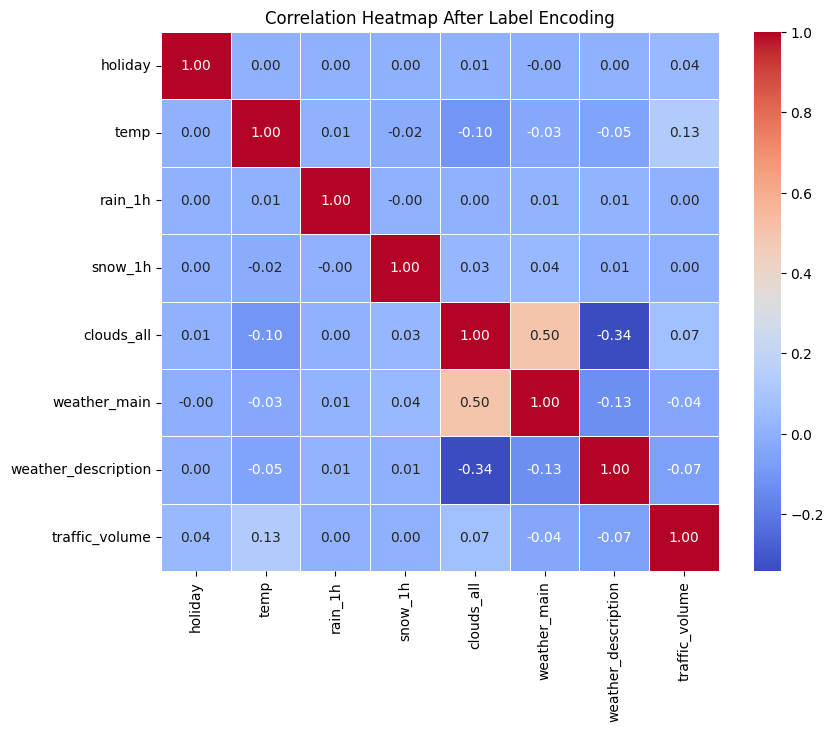

ADF Statistic: -28.019967663217848
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4304858126067175), '5%': np.float64(-2.8616000263321806), '10%': np.float64(-2.566801950040208)}

✅ Series is stationary


In [5]:

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)

# Label Encoding
label_encoders = {}
categorical_cols = ['holiday', 'weather_main', 'weather_description']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle outliers using IQR
Q1 = df['traffic_volume'].quantile(0.25)
Q3 = df['traffic_volume'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['traffic_volume'] >= lower_bound) & (df['traffic_volume'] <= upper_bound)]


# Compute correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap After Label Encoding")
plt.show()

# Create lag features
for lag in range(1, 4):  # 3 lag features
    df[f'lag_{lag}'] = df['traffic_volume'].shift(lag)
df.dropna(inplace=True)

# Normalize features
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
traffic_scaler = MinMaxScaler()
df['traffic_volume'] = traffic_scaler.fit_transform(df[['traffic_volume']])

# ADF test
adf_result = adfuller(df['traffic_volume'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

if adf_result[1] < 0.05:
    print("\n✅ Series is stationary")
else:
    print("\n❌ Series is NOT stationary")
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
X_train, y_train = train.drop(columns=['traffic_volume']), train['traffic_volume']
X_test, y_test = test.drop(columns=['traffic_volume']), test['traffic_volume']

# Convert to PyTorch tensors
X_train_torch, y_train_torch = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_test_torch, y_test_torch = torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**LSTM Model Implementation and Training**</p>

In [7]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# LSTM Predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = traffic_scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 0.0749 - val_loss: 0.0262
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - loss: 0.0313 - val_loss: 0.0123
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - loss: 0.0179 - val_loss: 0.0091
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - loss: 0.0124 - val_loss: 0.0063
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - loss: 0.0114 - val_loss: 0.0056
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - loss: 0.0103 - val_loss: 0.0055
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0097 - val_loss: 0.0050
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 9/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - loss: 0.0091 - val_loss: 0.0048
Epoch 10/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - loss: 0.0089 - val_loss: 0.0045
Epoch 11/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0091 - val_loss: 0.0049
Epoch 12/50
603/603 ━━━━━━━━━━

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**ARIMA Model Implementation and Training**</p>

In [6]:

#train_arima, test_arima = df['traffic_volume'][:train_size], df['traffic_volume'][train_size:]
#model_arima = ARIMA(train_arima, order=(5, 1, 0))
#model_arima_fit = model_arima.fit()
#y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))
#y_pred_arima = y_pred_arima[:len(y_test_inv)]


train_arima, test_arima = df['traffic_volume'][:train_size], df['traffic_volume'][train_size:]

# Grid Search for best (p, d, q)
best_aic = float("inf")
best_order = None
best_model_fit = None

# Define range for p, d, q
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_arima, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model_fit = model_fit
            except:
                continue

print(f"Best ARIMA Order: {best_order} with AIC: {best_aic}")

# Forecast using best model
y_pred_arima = best_model_fit.forecast(steps=len(test_arima))

# Align length just in case
y_pred_arima = y_pred_arima[:len(test_arima)]

Best ARIMA Order: (3, 0, 3) with AIC: -68260.98536103165


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**TSMixer Model Implementation and Training**</p>

In [8]:

class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

# Initialize and Train TSMixer Model
tsmixer_model = TSMixer(X_train_torch.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(tsmixer_model.parameters(), lr=0.0003, weight_decay=1e-4)

for epoch in range(500):
    tsmixer_model.train()
    optimizer.zero_grad()
    outputs = tsmixer_model(X_train_torch).squeeze()
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

# TSMixer Predictions
y_pred_tsmixer = tsmixer_model(X_test_torch).detach().numpy().flatten()
y_pred_tsmixer = traffic_scaler.inverse_transform(y_pred_tsmixer.reshape(-1, 1)).flatten()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Hybrid LSTM and TSMixer Model Implementation and Training**</p>

In [9]:
# ========================
# 1 DEFINE LSTM MODEL
# ========================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x, _ = self.lstm(x.unsqueeze(1))  # Add batch dimension
        x = self.fc(x[:, -1, :])
        return x

lstm_model = LSTMModel(X_train.shape[1])

In [10]:
# ========================
# 2 DEFINE TSMixer MODEL
# ========================
class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

tsmixer_model = TSMixer(X_train.shape[1])
# ========================
# 3 HYBRID MODEL (LSTM + TSMixer)
# ========================
class HybridModel(nn.Module):
    def __init__(self, input_dim):
        super(HybridModel, self).__init__()
        self.lstm = LSTMModel(input_dim)
        self.tsmixer = TSMixer(input_dim)
        self.fc = nn.Linear(2, 1)  # Combine both outputs

    def forward(self, x):
        lstm_out = self.lstm(x)
        tsmixer_out = self.tsmixer(x)
        combined = torch.cat((lstm_out, tsmixer_out), dim=1)
        return self.fc(combined)

hybrid_model = HybridModel(X_train.shape[1])
# ========================
# 4 TRAINING
# ========================
criterion = nn.MSELoss()
optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001, weight_decay=1e-4)

batch_size = 64
num_epochs = 500

train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    hybrid_model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = hybrid_model(batch_X).squeeze()
        loss = criterion(outputs, batch_y.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


Epoch [10/500], Loss: 0.0094
Epoch [20/500], Loss: 0.0083
Epoch [30/500], Loss: 0.0078
Epoch [40/500], Loss: 0.0074
Epoch [50/500], Loss: 0.0071
Epoch [60/500], Loss: 0.0070
Epoch [70/500], Loss: 0.0068
Epoch [80/500], Loss: 0.0067
Epoch [90/500], Loss: 0.0066
Epoch [100/500], Loss: 0.0065
Epoch [110/500], Loss: 0.0064
Epoch [120/500], Loss: 0.0064
Epoch [130/500], Loss: 0.0063
Epoch [140/500], Loss: 0.0063
Epoch [150/500], Loss: 0.0063
Epoch [160/500], Loss: 0.0062
Epoch [170/500], Loss: 0.0062
Epoch [180/500], Loss: 0.0062
Epoch [190/500], Loss: 0.0061
Epoch [200/500], Loss: 0.0061
Epoch [210/500], Loss: 0.0061
Epoch [220/500], Loss: 0.0060
Epoch [230/500], Loss: 0.0060
Epoch [240/500], Loss: 0.0060
Epoch [250/500], Loss: 0.0060
Epoch [260/500], Loss: 0.0060
Epoch [270/500], Loss: 0.0060
Epoch [280/500], Loss: 0.0059
Epoch [290/500], Loss: 0.0059
Epoch [300/500], Loss: 0.0059
Epoch [310/500], Loss: 0.0059
Epoch [320/500], Loss: 0.0059
Epoch [330/500], Loss: 0.0059
Epoch [340/500], Lo

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**hybrid KNN LSTM Implementation and Training**</p>

In [11]:
# ========================
#  KNN MODEL FOR FEATURE SELECTION
# ========================
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
X_train_knn = knn.predict(X_train).reshape(-1, 1)
X_test_knn = knn.predict(X_test).reshape(-1, 1)

# ========================
#  KNN-LSTM MODEL
# ========================
def build_knn_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape for LSTM
X_train_knn_lstm = np.reshape(X_train_knn, (X_train_knn.shape[0], 1, 1))
X_test_knn_lstm = np.reshape(X_test_knn, (X_test_knn.shape[0], 1, 1))

knn_lstm_model = build_knn_lstm_model((1, 1))
knn_lstm_model.fit(X_train_knn_lstm, y_train, epochs=10, batch_size=32, verbose=1)
y_pred_knn_lstm = knn_lstm_model.predict(X_test_knn_lstm)

# Rescale predictions back to original scale
y_pred_knn_lstm = traffic_scaler.inverse_transform(y_pred_knn_lstm)
y_test_rescaled = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

Epoch 1/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0554
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0082
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0073
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0072
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0070
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0068
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0069
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0065
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0066
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0068
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet Model Implementation and Training**</p>

In [12]:
# ========================
#  IMPLEMENT DASNet
# ========================
class DASNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(DASNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out.squeeze()

# Model setup
input_dim = X_train_torch.shape[1]
dasnet = DASNet(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(dasnet.parameters(), lr=0.001)

# Prepare data for training
train_dataset = TensorDataset(X_train_torch.unsqueeze(1), y_train_torch)
test_dataset = TensorDataset(X_test_torch.unsqueeze(1), y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
epochs = 20
for epoch in range(epochs):
    dasnet.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = dasnet(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

# ========================
#  EVALUATION (UPDATED)
# ========================
dasnet.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = dasnet(X_batch)
        y_pred_list.append(y_pred.numpy())
        y_true_list.append(y_batch.numpy())

y_pred_list = np.concatenate(y_pred_list)
y_true_list = np.concatenate(y_true_list)

# Convert back to original scale
y_pred_actual_Dasnet = traffic_scaler.inverse_transform(y_pred_list.reshape(-1, 1))
y_true_actual = traffic_scaler.inverse_transform(y_true_list.reshape(-1, 1))

Epoch 1/20, Loss: 0.0290
Epoch 2/20, Loss: 0.0098
Epoch 3/20, Loss: 0.0092
Epoch 4/20, Loss: 0.0089
Epoch 5/20, Loss: 0.0086
Epoch 6/20, Loss: 0.0083
Epoch 7/20, Loss: 0.0082
Epoch 8/20, Loss: 0.0080
Epoch 9/20, Loss: 0.0078
Epoch 10/20, Loss: 0.0078
Epoch 11/20, Loss: 0.0077
Epoch 12/20, Loss: 0.0076
Epoch 13/20, Loss: 0.0076
Epoch 14/20, Loss: 0.0075
Epoch 15/20, Loss: 0.0075
Epoch 16/20, Loss: 0.0074
Epoch 17/20, Loss: 0.0074
Epoch 18/20, Loss: 0.0074
Epoch 19/20, Loss: 0.0073
Epoch 20/20, Loss: 0.0073


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet LSTM Model Implementation and Training**</p>

In [13]:
# Define GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        x = torch.matmul(adj, x.T).T  # Fix dimension mismatch
        return torch.relu(self.fc(x))

# Define DASNet-LSTM Model
class DASNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_units, adj_matrix):
        super(DASNetLSTM, self).__init__()
        self.adj = torch.tensor(adj_matrix, dtype=torch.float32)
        self.gcn = GCNLayer(input_dim, hidden_dim)
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc = nn.Linear(lstm_units, 1)

    def forward(self, x):
        x = self.gcn(x, self.adj)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = x * attn_weights  # Apply attention
        x = x.unsqueeze(1)  # LSTM expects (batch, seq_len, features)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])  # Final output

# Adjacency matrix (Identity as placeholder)
adj_matrix = np.eye(X_train.shape[1])


In [14]:
model = DASNetLSTM(input_dim=X_train.shape[1], hidden_dim=64, lstm_units=32, adj_matrix=adj_matrix)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# Training loop
num_epochs = 600

# Convert X_train to a PyTorch tensor before feeding it into the model
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # Also convert y_train for consistency

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze() # Pass the tensor here
    loss = criterion(outputs, y_train_tensor) # Pass the tensor here
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/600], Loss: 0.2563
Epoch [20/600], Loss: 0.2268
Epoch [30/600], Loss: 0.1968
Epoch [40/600], Loss: 0.1651
Epoch [50/600], Loss: 0.1317
Epoch [60/600], Loss: 0.0990
Epoch [70/600], Loss: 0.0737
Epoch [80/600], Loss: 0.0643
Epoch [90/600], Loss: 0.0628
Epoch [100/600], Loss: 0.0579
Epoch [110/600], Loss: 0.0530
Epoch [120/600], Loss: 0.0472
Epoch [130/600], Loss: 0.0415
Epoch [140/600], Loss: 0.0367
Epoch [150/600], Loss: 0.0332
Epoch [160/600], Loss: 0.0307
Epoch [170/600], Loss: 0.0286
Epoch [180/600], Loss: 0.0266
Epoch [190/600], Loss: 0.0247
Epoch [200/600], Loss: 0.0226
Epoch [210/600], Loss: 0.0205
Epoch [220/600], Loss: 0.0184
Epoch [230/600], Loss: 0.0161
Epoch [240/600], Loss: 0.0138
Epoch [250/600], Loss: 0.0120
Epoch [260/600], Loss: 0.0111
Epoch [270/600], Loss: 0.0107
Epoch [280/600], Loss: 0.0105
Epoch [290/600], Loss: 0.0103
Epoch [300/600], Loss: 0.0101
Epoch [310/600], Loss: 0.0100
Epoch [320/600], Loss: 0.0099
Epoch [330/600], Loss: 0.0098
Epoch [340/600], Lo

In [15]:
# Evaluate model
model.eval()
# Convert X_test to a PyTorch tensor before feeding it into the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32) # Convert X_test to Tensor
y_pred_Dasnet_LSTM = model(X_test_tensor).detach().numpy() # Pass the tensor to the model


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing TimeMixer Model**</p>

In [16]:
# Define TimeMixer model
class TimeMixerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(TimeMixerBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

class TimeMixer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_blocks=3):
        super(TimeMixer, self).__init__()
        self.mixer_blocks = nn.Sequential(
            *[TimeMixerBlock(input_dim, hidden_dim) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.mixer_blocks(x)
        x = self.output_layer(x)
        return x.squeeze()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, loss, optimizer
input_dim = X_train.shape[1]
model = TimeMixer(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to device
X_train_torch = X_train_torch.to(device)
y_train_torch = y_train_torch.to(device)
X_test_torch = X_test_torch.to(device)
y_test_torch = y_test_torch.to(device)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_torch)
            val_loss = criterion(val_outputs, y_test_torch)
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Test Loss: {val_loss.item():.4f}")

# Prediction
model.eval()
with torch.no_grad():
    y_pred_TimeMixer = model(X_test_torch).cpu().numpy()
    y_true = y_test_torch.cpu().numpy()


Epoch [10/500] | Train Loss: 0.0554 | Test Loss: 0.0329
Epoch [20/500] | Train Loss: 0.0427 | Test Loss: 0.0240
Epoch [30/500] | Train Loss: 0.0346 | Test Loss: 0.0170
Epoch [40/500] | Train Loss: 0.0280 | Test Loss: 0.0122
Epoch [50/500] | Train Loss: 0.0251 | Test Loss: 0.0097
Epoch [60/500] | Train Loss: 0.0224 | Test Loss: 0.0082
Epoch [70/500] | Train Loss: 0.0204 | Test Loss: 0.0078
Epoch [80/500] | Train Loss: 0.0192 | Test Loss: 0.0074
Epoch [90/500] | Train Loss: 0.0182 | Test Loss: 0.0072
Epoch [100/500] | Train Loss: 0.0171 | Test Loss: 0.0071
Epoch [110/500] | Train Loss: 0.0167 | Test Loss: 0.0069
Epoch [120/500] | Train Loss: 0.0158 | Test Loss: 0.0068
Epoch [130/500] | Train Loss: 0.0153 | Test Loss: 0.0066
Epoch [140/500] | Train Loss: 0.0148 | Test Loss: 0.0065
Epoch [150/500] | Train Loss: 0.0144 | Test Loss: 0.0064
Epoch [160/500] | Train Loss: 0.0140 | Test Loss: 0.0063
Epoch [170/500] | Train Loss: 0.0137 | Test Loss: 0.0062
Epoch [180/500] | Train Loss: 0.0133 | T

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Evaluations of the models**</p>

In [17]:
# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32)

# Ensure input is 3D for LSTM: [batch, seq_len=1, input_dim]
if X_train_torch.dim() == 2:
    X_train_torch = X_train_torch.unsqueeze(1)
if X_test_torch.dim() == 2:
    X_test_torch = X_test_torch.unsqueeze(1)

# --- TimeMixer Block ---
class TimeMixerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(TimeMixerBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

# --- Hybrid LSTM + TimeMixer Model ---
class HybridLSTMTimeMixer(nn.Module):
    def __init__(self, input_dim, lstm_hidden=64, tm_hidden=64, num_tm_blocks=2):
        super(HybridLSTMTimeMixer, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.tm_blocks = nn.Sequential(
            *[TimeMixerBlock(lstm_hidden, tm_hidden) for _ in range(num_tm_blocks)]
        )
        self.output_layer = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)       # Output shape: [batch, seq_len=1, lstm_hidden]
        x = lstm_out.squeeze(1)          # Remove seq dim -> [batch, lstm_hidden]
        x = self.tm_blocks(x)            # Pass through TimeMixer blocks
        out = self.output_layer(x)       # Output layer
        return out.squeeze()             # Final output: [batch]

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
input_dim = X_train.shape[1]
model = HybridLSTMTimeMixer(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to device
X_train_torch = X_train_torch.to(device)
X_test_torch = X_test_torch.to(device)
y_train_torch = y_train_torch.to(device)
y_test_torch = y_test_torch.to(device)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_torch)
            val_loss = criterion(val_outputs, y_test_torch)
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Test Loss: {val_loss.item():.4f}")

# Prediction
model.eval()
with torch.no_grad():
    y_pred_TimeMixer = model(X_test_torch).cpu().numpy()
    y_true = y_test_torch.cpu().numpy()

# Inverse transform to original scale
y_pred_TimeMixer_LSTM = traffic_scaler.inverse_transform(y_pred_TimeMixer.reshape(-1, 1)).flatten()
y_true_actual = traffic_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()


Epoch [10/500] | Train Loss: 0.0644 | Test Loss: 0.0329
Epoch [20/500] | Train Loss: 0.0441 | Test Loss: 0.0317
Epoch [30/500] | Train Loss: 0.0300 | Test Loss: 0.0209
Epoch [40/500] | Train Loss: 0.0261 | Test Loss: 0.0158
Epoch [50/500] | Train Loss: 0.0219 | Test Loss: 0.0120
Epoch [60/500] | Train Loss: 0.0184 | Test Loss: 0.0091
Epoch [70/500] | Train Loss: 0.0165 | Test Loss: 0.0077
Epoch [80/500] | Train Loss: 0.0150 | Test Loss: 0.0070
Epoch [90/500] | Train Loss: 0.0139 | Test Loss: 0.0067
Epoch [100/500] | Train Loss: 0.0132 | Test Loss: 0.0064
Epoch [110/500] | Train Loss: 0.0126 | Test Loss: 0.0062
Epoch [120/500] | Train Loss: 0.0123 | Test Loss: 0.0061
Epoch [130/500] | Train Loss: 0.0118 | Test Loss: 0.0060
Epoch [140/500] | Train Loss: 0.0116 | Test Loss: 0.0059
Epoch [150/500] | Train Loss: 0.0113 | Test Loss: 0.0058
Epoch [160/500] | Train Loss: 0.0110 | Test Loss: 0.0057
Epoch [170/500] | Train Loss: 0.0108 | Test Loss: 0.0056
Epoch [180/500] | Train Loss: 0.0105 | T

In [18]:
# ========================
# 6⃣ MODEL EVALUATION
# ========================
hybrid_model.eval()
with torch.no_grad():
    # Reshape X_test_torch to 3D for LSTM
    y_test_pred = hybrid_model(X_test_torch.squeeze(1)).squeeze().numpy()  # Remove extra dimension

# Inverse transform predictions
y_test_pred_inv = traffic_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test_actual_inv = traffic_scaler.inverse_transform(y_test_torch.numpy().reshape(-1, 1)).flatten()
# Metrics calculation
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero_indices = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return round(mse, 5), round(rmse, 5), round(mae, 5), round(mape, 5), round(r2, 5)

# Evaluate models
metrics_hybrid = evaluate_model(y_test_actual_inv, y_test_pred_inv)
metrics_lstm = evaluate_model(y_test_actual_inv, y_pred_lstm)
metrics_arima = evaluate_model(y_test_actual_inv, y_pred_arima)
metrics_tsmixer = evaluate_model(y_test_actual_inv, y_pred_tsmixer)
metrics_knn_lstm = evaluate_model(y_test_actual_inv, y_pred_knn_lstm)
metrics_dasnet = evaluate_model(y_test_actual_inv, y_pred_actual_Dasnet)
metrics_dasnet_lstm=evaluate_model(y_test_actual_inv,y_pred_Dasnet_LSTM)
metrics_TimeMixer=evaluate_model(y_test_actual_inv,y_pred_TimeMixer)
metrics_TimeMixer_LSTM=evaluate_model(y_test_actual_inv,y_pred_TimeMixer_LSTM)

# PrettyTable for Model Comparison
table = PrettyTable()
table.field_names = ["Model", "MSE", "RMSE", "MAE", "MAPE", "R²"]
table.add_row(["LSTM", *metrics_lstm])
table.add_row(["ARIMA", *metrics_arima])
table.add_row(["TSMixer", *metrics_tsmixer])
table.add_row(["Hybrid LSTM-TSMixer", *metrics_hybrid])
table.add_row(["Hybrid KNN-LSTM", *metrics_knn_lstm])
table.add_row(["DasNet",*metrics_dasnet])
table.add_row(["Hybrid DasNet LSTM",*metrics_dasnet_lstm])
table.add_row(["TimeMixer",*metrics_TimeMixer])
table.add_row(["Hybrid TimeMixer-LSTM",*metrics_TimeMixer_LSTM])

print(table)


+-----------------------+---------+---------+---------+-----------+---------+
|         Model         |   MSE   |   RMSE  |   MAE   |    MAPE   |    R²   |
+-----------------------+---------+---------+---------+-----------+---------+
|          LSTM         | 0.00355 |  0.0596 | 0.04119 |  14.66589 | 0.95138 |
|         ARIMA         | 0.07302 | 0.27022 | 0.23653 | 171.01253 | 0.00044 |
|        TSMixer        | 0.01016 | 0.10078 | 0.07665 |  32.40224 | 0.86097 |
|  Hybrid LSTM-TSMixer  | 0.00333 | 0.05769 | 0.03928 |  16.4988  | 0.95444 |
|    Hybrid KNN-LSTM    | 0.00434 | 0.06591 | 0.04567 | 188.09135 | 0.94053 |
|         DasNet        |  0.0052 | 0.07209 | 0.05396 |  190.7115 | 0.92886 |
|   Hybrid DasNet LSTM  | 0.00605 | 0.07779 | 0.05616 | 187.23557 | 0.91716 |
|       TimeMixer       |  0.0047 | 0.06854 | 0.04735 |  16.65014 | 0.93569 |
| Hybrid TimeMixer-LSTM |  0.0047 | 0.06854 | 0.04735 |  16.65014 | 0.93569 |
+-----------------------+---------+---------+---------+---------

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Plotting**</p>

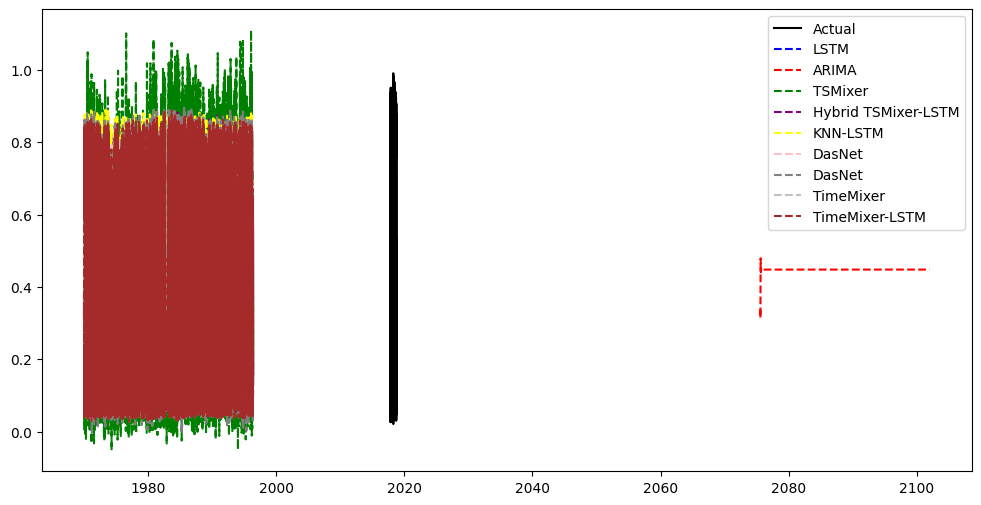

In [19]:
# ========================
# 6️⃣ PLOT MODEL PREDICTIONS
# ========================
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color='black')
plt.plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
plt.plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
plt.plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
plt.plot( y_test_pred, label="Hybrid TSMixer-LSTM", linestyle='dashed', color='purple')
plt.plot(y_pred_knn_lstm, label="KNN-LSTM", linestyle='dashed', color='yellow')
plt.plot(y_pred_actual_Dasnet, label="DasNet", linestyle='dashed', color='pink')
plt.plot(y_pred_Dasnet_LSTM, label="DasNet", linestyle='dashed', color='grey')
plt.plot(y_pred_TimeMixer, label="TimeMixer", linestyle='dashed', color='silver')
plt.plot(y_pred_TimeMixer_LSTM, label="TimeMixer-LSTM", linestyle='dashed', color='brown')
plt.legend()
plt.show()



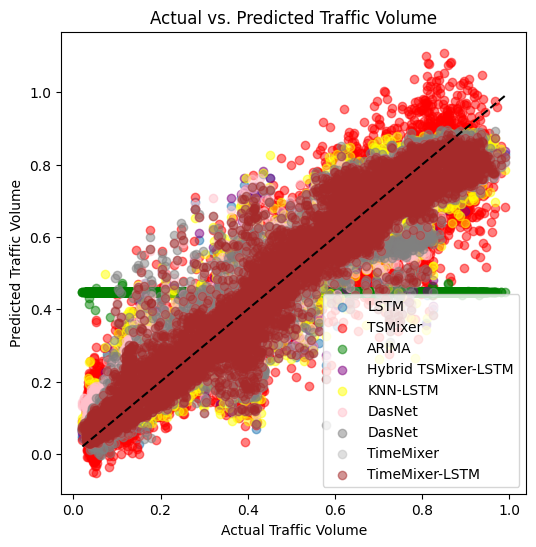

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.scatter(y_test, y_pred_arima, alpha=0.5, label="ARIMA", color='green')
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.scatter(y_test, y_pred_Dasnet_LSTM, alpha=0.5, label="DasNet", color='grey')
plt.scatter(y_test, y_pred_TimeMixer, alpha=0.5, label="TimeMixer", color='silver')
plt.scatter(y_test, y_pred_TimeMixer_LSTM, alpha=0.5, label="TimeMixer-LSTM", color='brown')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()


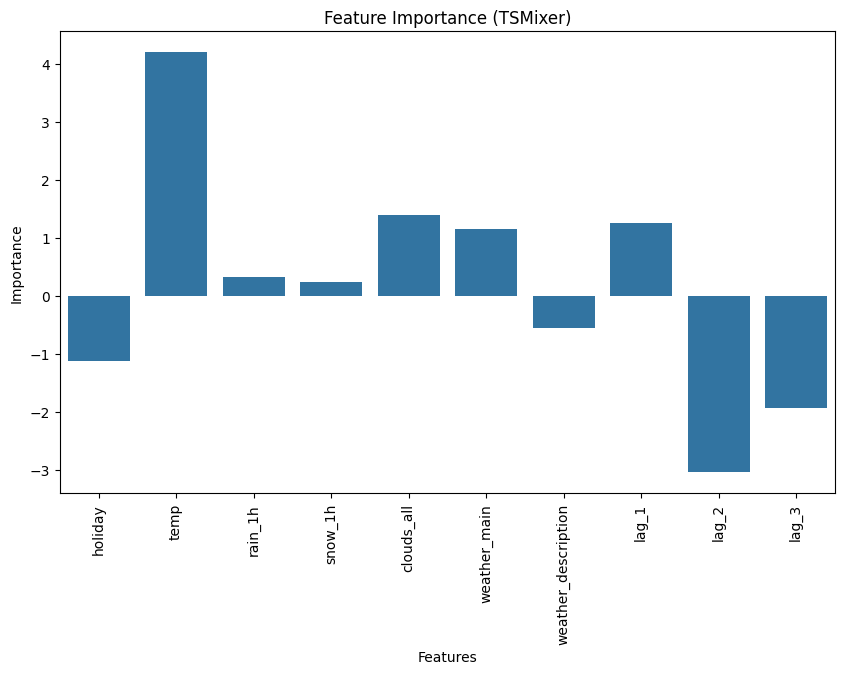

In [21]:
import seaborn as sns
importance = tsmixer_model.fc1.weight.detach().numpy().sum(axis=0)  # Example for TSMixer
plt.figure(figsize=(10, 6))
sns.barplot(x=X_train.columns, y=importance)
plt.xticks(rotation=90)
plt.title("Feature Importance (TSMixer)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

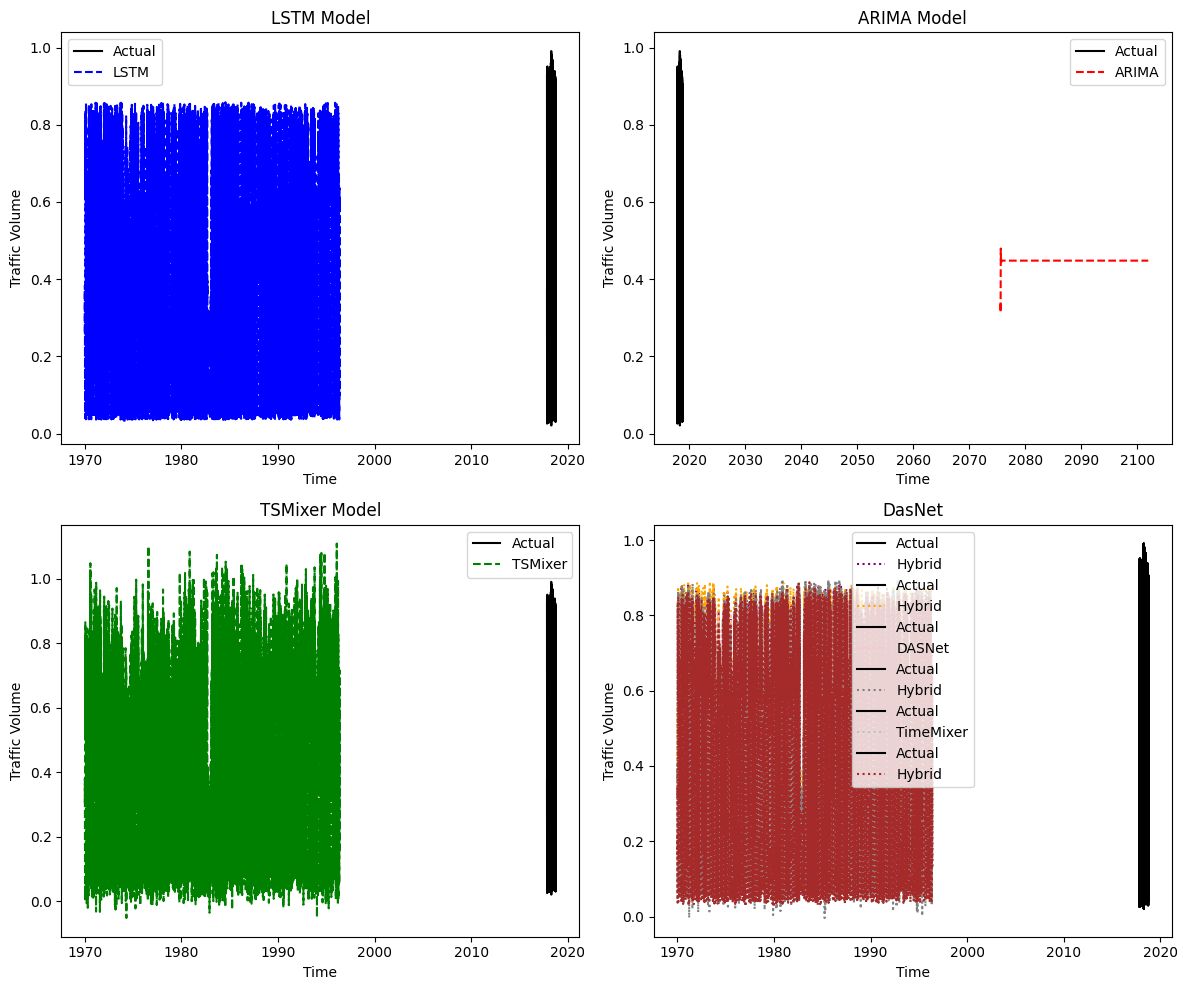

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(y_test, label="Actual", color='black')
axes[0, 0].plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
axes[0, 0].set_title("LSTM Model")

axes[0, 1].plot(y_test, label="Actual", color='black')
axes[0, 1].plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
axes[0, 1].set_title("ARIMA Model")

axes[1, 0].plot(y_test, label="Actual", color='black')
axes[1, 0].plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
axes[1, 0].set_title("TSMixer Model")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_test_pred, label="Hybrid", linestyle='dotted', color='purple')
axes[1, 1].set_title("Hybrid TSMixer-LSTM")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_knn_lstm, label="Hybrid", linestyle='dotted', color='orange')
axes[1, 1].set_title("KNN LTM")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_actual_Dasnet, label="DASNet", linestyle='dotted', color='pink')
axes[1, 1].set_title("DasNet")


axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_Dasnet_LSTM, label="Hybrid", linestyle='dotted', color='grey')
axes[1, 1].set_title("DasNet")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_TimeMixer, label="TimeMixer", linestyle='dotted', color='silver')
axes[1, 1].set_title("TimeMixer")
axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_TimeMixer_LSTM, label="Hybrid", linestyle='dotted', color='brown')
axes[1, 1].set_title("DasNet")




for ax in axes.flat:
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Traffic Volume")

plt.tight_layout()
plt.show()


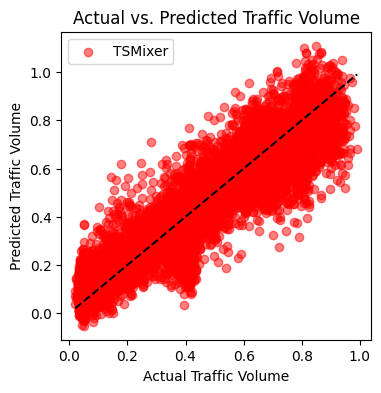

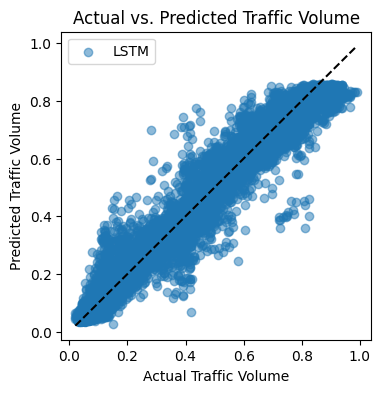

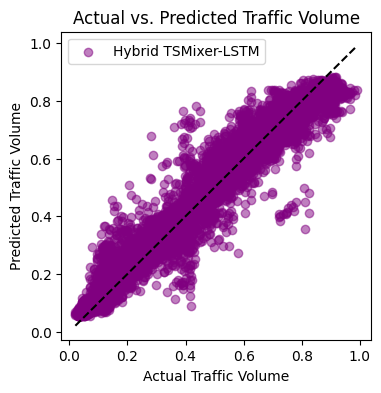

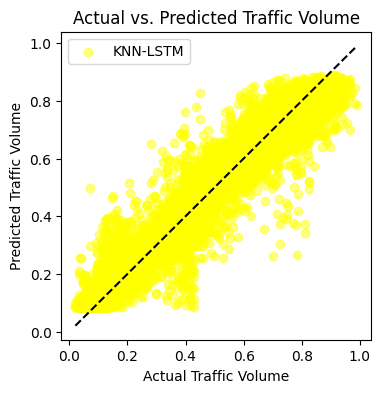

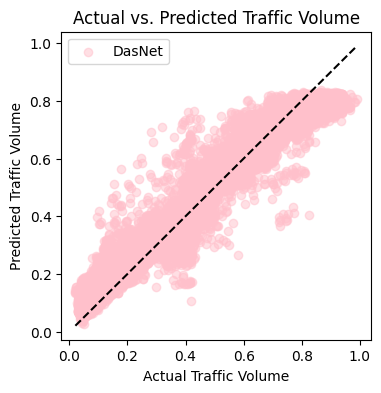

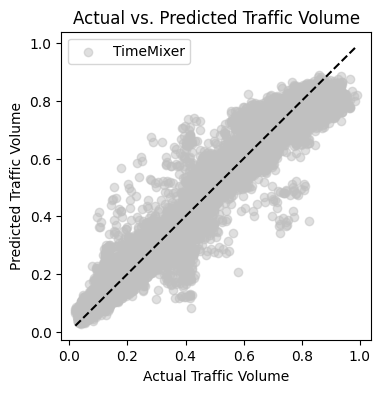

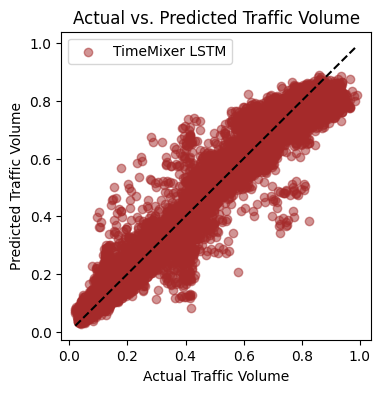

In [23]:
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_TimeMixer, alpha=0.5, label="TimeMixer", color='silver')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()


plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_TimeMixer_LSTM, alpha=0.5, label="TimeMixer LSTM", color='brown')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()